# Model Comparison and Feature Selection

This notebook provides supervised learning tools to understand associations between the target variable and the predictors. The supporting Python code is in ModelTools.py. Many of the functions have additional arguments that are defaulted. For more details look through the code. Also add any functions you find useful.

# Outline 

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Part One - Univariate Analysis](#part-one---univariate-analysis)
    - [Load Data and Specify Variables](#load-data-and-specify-variables)
    - [One Hot Encode Categorical Variables](#one-hot-encode-categorical-variables)
    - [Linear Univariate Analysis](#linear-univariate-analysis)
    - [Random Forest Univariate Analysis](#random-forest-univariate-analysis)
    - [Gradient Boosting Univariate Analysis](#gradient-boosting-univariate-analysis)
- [Part Two - Model Comparison](#part-two---model-comparison)
- [Part Three - Variable Selection](#part-three---variable-selection)
    - [Random Forest](#random-forest)
    - [Gradient Boosting](#gradient-boosting)

<!-- MarkdownTOC -->

<a name="part-one---univariate-analysis"></a>
# Part One - Univariate Analysis

<a name="load-data-and-specify-variables"></a>
## Load Data and Specify Variables

For this example, we use the HousePrice dataset from Kaggle, that can be found here:

<a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data">https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data</a>

In this section we will load our dataset, print the index of each feature and then specify which variables are predictors, target, controls (optional), and weight (optional). For variables with null values, null_value_cleanup will create IS_NULL indicator variables. If you prefer another method of dealing with missing values, like imputing values (e.g. mean, median, mode), write a function to do it, put it in EDATools, and call it below. 

In [1]:
import EDATools
import ModelTools
import pandas as pd
import numpy as np
import warnings

dataset = pd.read_csv("HousePrice_Regression/train.csv")  # Replace with the location on your computer.
dataset.rename(columns={'1stFlrSF': 'FirstFlrSF', '2ndFlrSF': 'SecondFlrSF', '3SsnPorch': 'ThreeSsnPorch'}, inplace=True)

EDATools.null_value_cleanup(dataset)

# Print the index of each feature.
for i, col in enumerate(dataset.columns):
    print(i, col)

0 Id
1 MSSubClass
2 MSZoning
3 LotFrontage
4 LotFrontage_ISNULL
5 LotArea
6 Street
7 Alley
8 LotShape
9 LandContour
10 Utilities
11 LotConfig
12 LandSlope
13 Neighborhood
14 Condition1
15 Condition2
16 BldgType
17 HouseStyle
18 OverallQual
19 OverallCond
20 YearBuilt
21 YearRemodAdd
22 RoofStyle
23 RoofMatl
24 Exterior1st
25 Exterior2nd
26 MasVnrType
27 MasVnrArea
28 MasVnrArea_ISNULL
29 ExterQual
30 ExterCond
31 Foundation
32 BsmtQual
33 BsmtCond
34 BsmtExposure
35 BsmtFinType1
36 BsmtFinSF1
37 BsmtFinType2
38 BsmtFinSF2
39 BsmtUnfSF
40 TotalBsmtSF
41 Heating
42 HeatingQC
43 CentralAir
44 Electrical
45 FirstFlrSF
46 SecondFlrSF
47 LowQualFinSF
48 GrLivArea
49 BsmtFullBath
50 BsmtHalfBath
51 FullBath
52 HalfBath
53 BedroomAbvGr
54 KitchenAbvGr
55 KitchenQual
56 TotRmsAbvGrd
57 Functional
58 Fireplaces
59 FireplaceQu
60 GarageType
61 GarageYrBlt
62 GarageYrBlt_ISNULL
63 GarageFinish
64 GarageCars
65 GarageArea
66 GarageQual
67 GarageCond
68 PavedDrive
69 WoodDeckSF
70 OpenPorchSF
71 Enc

Set index of predictors, target, controls, weight.

In [2]:
predictors = np.arange(1,83)
numeric_cat_index = np.array([1,4,18,19,28,62,79])
target = 83

<a name="one-hot-encode-categorical-variables"></a>
## One Hot Encode Categorical Variables

For the purpose of modeling we will one-hot encode each categorical variable. We will also re-name our features so that categorical variables follow the convention VariableName-LevelName. This will allow us to keep track of variable level characteristics, in particular variable importance.

In [3]:
dataset_enc = ModelTools.CreateDummyVars(dataset,predictors,target,numeric_cat_index)

In [4]:
for i, col in enumerate(dataset_enc.columns):
    print(i, col)

0 MSSubClass-20
1 MSSubClass-30
2 MSSubClass-40
3 MSSubClass-45
4 MSSubClass-50
5 MSSubClass-60
6 MSSubClass-70
7 MSSubClass-75
8 MSSubClass-80
9 MSSubClass-85
10 MSSubClass-90
11 MSSubClass-120
12 MSSubClass-160
13 MSSubClass-180
14 MSSubClass-190
15 MSZoning-C (all)
16 MSZoning-FV
17 MSZoning-RH
18 MSZoning-RL
19 MSZoning-RM
20 LotFrontage_ISNULL-0
21 LotFrontage_ISNULL-1
22 Street-Grvl
23 Street-Pave
24 Alley-Grvl
25 Alley-Null_Value
26 Alley-Pave
27 LotShape-IR1
28 LotShape-IR2
29 LotShape-IR3
30 LotShape-Reg
31 LandContour-Bnk
32 LandContour-HLS
33 LandContour-Low
34 LandContour-Lvl
35 Utilities-AllPub
36 Utilities-NoSeWa
37 LotConfig-Corner
38 LotConfig-CulDSac
39 LotConfig-FR2
40 LotConfig-FR3
41 LotConfig-Inside
42 LandSlope-Gtl
43 LandSlope-Mod
44 LandSlope-Sev
45 Neighborhood-Blmngtn
46 Neighborhood-Blueste
47 Neighborhood-BrDale
48 Neighborhood-BrkSide
49 Neighborhood-ClearCr
50 Neighborhood-CollgCr
51 Neighborhood-Crawfor
52 Neighborhood-Edwards
53 Neighborhood-Gilbert
54 N

Split the data into a training and validation set, with the validation set containing p_val_size (defaulted to 0.2) portion of the data.

In [5]:
warnings.filterwarnings('ignore')

predictors_enc = np.arange(352)
target_enc = 352
 
X_train, X_val, Y_train, Y_val = ModelTools.TrainHoldSplit(dataset_enc,predictors_enc,target_enc,p_val_size=0.25)

<a name="linear-univariate-analysis"></a>
## Linear Univariate Analysis

A univariate linear analysis gives us a basic intuition of the relationship between our predictors and our target variable. However it does not account for any correlations that exist, therefore it is not recommended for variable selection. For each predictor we will fit a linear model on the training set and compute the performance on the validation set. For binary classification problems, set p_model = 'binary' for logistic regression; for continuous regression problems, set p_model = 'continuous' and choose the appropriate distribution and link function (defaulted to gamma and log link).
<br>
A list of the top p_top_k_features (defaulted to 5) features will be shown, ordered by their performance on the validation set, and below a graph of the univariate fit will be given along with additional statistics. For each categorical predictor, the fitted value and 95% confidence interval are graphed on the primary axis. On the secondary axis, the weight/count in each level is given as a bar chart. For continuous predictors, the fitted value is graphed with either a scatter plot of the data or p_n_buckets (defaulted to 20) average values, for continuous and classification target variables respectively.

        Variable  Validation Error
17   OverallQual      30455.629122
12  Neighborhood      37820.327500
28     ExterQual      39290.158170
31      BsmtQual      39511.808730
54   KitchenQual      40068.269069
63    GarageCars      41887.406493
47     GrLivArea      42842.677781
64    GarageArea      43862.178354
62  GarageFinish      44262.162959
50      FullBath      45355.859632
19     YearBuilt      45885.123812
59    GarageType      46565.689728
44    FirstFlrSF      46937.378481
0     MSSubClass      47831.339373
20  YearRemodAdd      47957.068362
58   FireplaceQu      48316.251942
30    Foundation      48851.875171
55  TotRmsAbvGrd      49072.711175
39   TotalBsmtSF      50759.505502
57    Fireplaces      50763.455976
26    MasVnrArea      50848.704183
41     HeatingQC      51047.457528
34  BsmtFinType1      51337.733114
33  BsmtExposure      51469.755958
23   Exterior1st      51816.044438
1       MSZoning      52319.157344
24   Exterior2nd      52505.011180
68    WoodDeckSF    

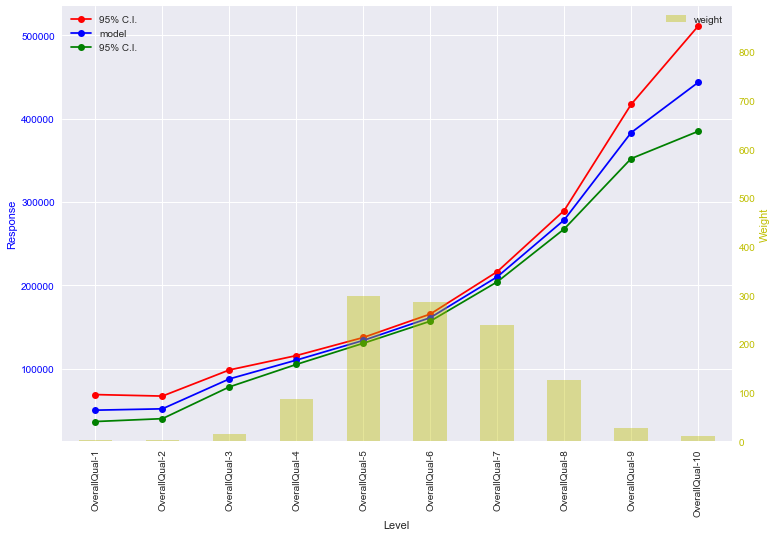

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1085
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                 0.0523753009458
Method:                          IRLS   Log-Likelihood:                -13113.
Date:                Thu, 11 Jan 2018   Deviance:                       57.839
Time:                        20:54:14   Pearson chi2:                     56.8
No. Iterations:                     5                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
OverallQual-1     10.8228      0.162     66.879      0.000      10.506      11.140
OverallQual-2     10.8546      0.132    

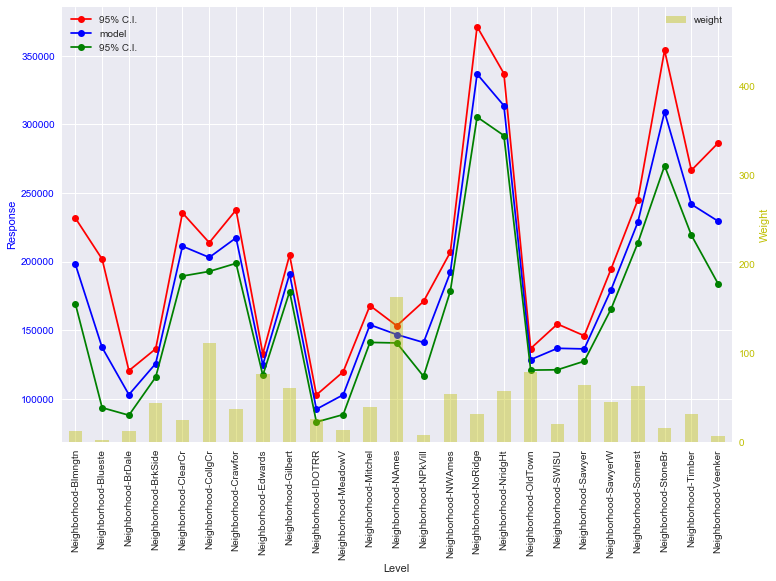

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1070
Model Family:                   Gamma   Df Model:                           24
Link Function:                    log   Scale:                 0.0768100135849
Method:                          IRLS   Log-Likelihood:                -13264.
Date:                Thu, 11 Jan 2018   Deviance:                       75.435
Time:                        20:54:14   Pearson chi2:                     82.2
No. Iterations:                     4                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Neighborhood-Blmngtn    12.1969      0.080    152.451      0.000      12.040      12.354
Neighborhood-Blueste  

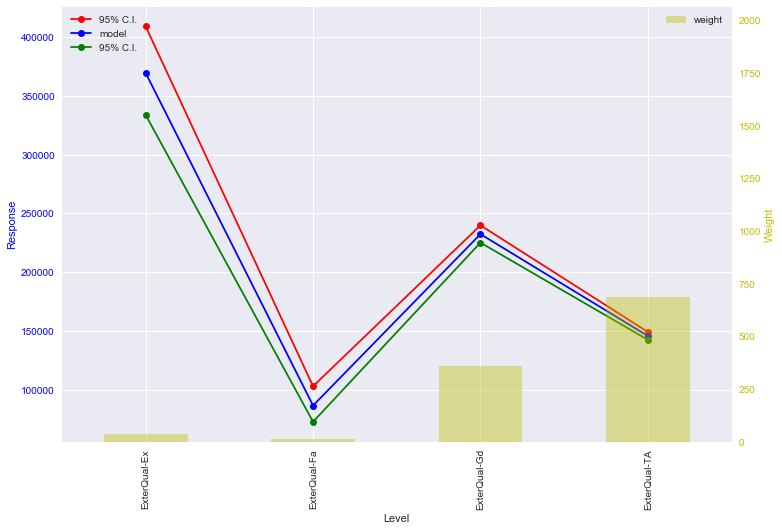

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1091
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                 0.0941193408073
Method:                          IRLS   Log-Likelihood:                -13407.
Date:                Thu, 11 Jan 2018   Deviance:                       98.195
Time:                        20:54:14   Pearson chi2:                     103.
No. Iterations:                     4                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ExterQual-Ex    12.8195      0.052    247.210      0.000      12.718      12.921
ExterQual-Fa    11.3691      0.089    128.375 

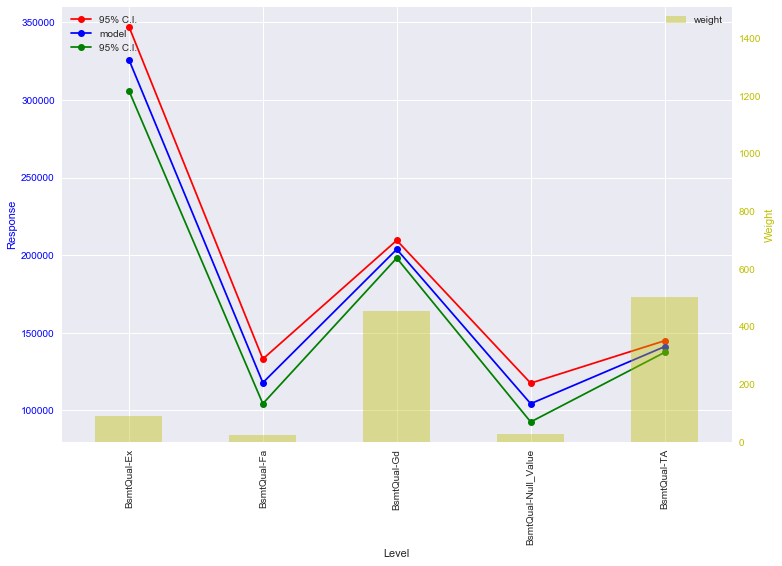

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1090
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                  0.092874257017
Method:                          IRLS   Log-Likelihood:                -13401.
Date:                Thu, 11 Jan 2018   Deviance:                       97.153
Time:                        20:54:15   Pearson chi2:                     101.
No. Iterations:                     4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
BsmtQual-Ex            12.6947      0.032    392.979      0.000      12.631      12.758
BsmtQual-Fa            11

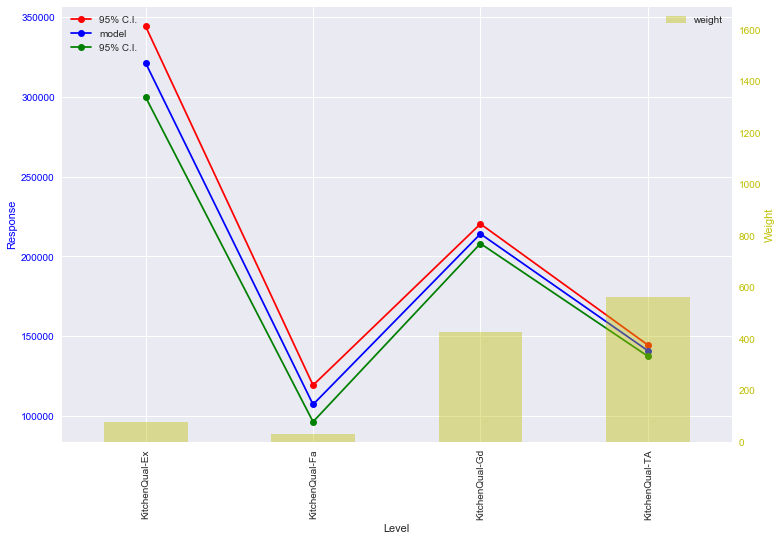

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1091
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                 0.0917971474117
Method:                          IRLS   Log-Likelihood:                -13408.
Date:                Thu, 11 Jan 2018   Deviance:                       98.502
Time:                        20:54:15   Pearson chi2:                     100.
No. Iterations:                     4                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
KitchenQual-Ex    12.6800      0.035    360.014      0.000      12.611      12.749
KitchenQual-Fa    11.5827      0.054    

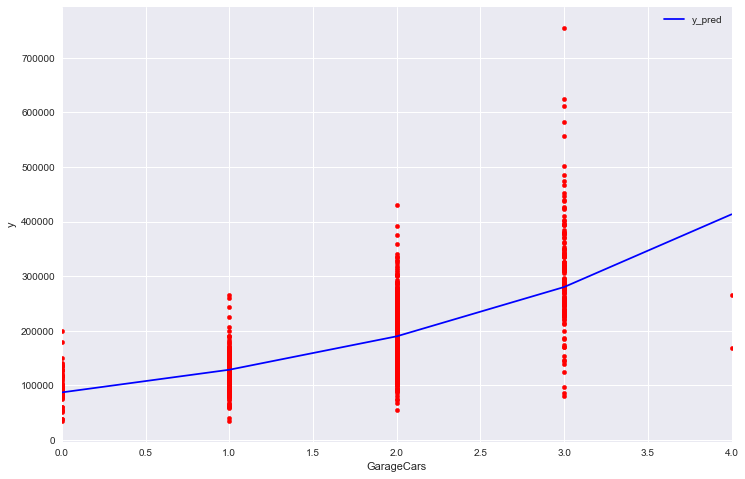

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                 0.0830927372051
Method:                          IRLS   Log-Likelihood:                -13356.
Date:                Thu, 11 Jan 2018   Deviance:                       89.642
Time:                        20:54:15   Pearson chi2:                     90.8
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3775      0.023    501.403      0.000      11.333      11.422
GarageCars     0.3886      0.012     32.725      0.0

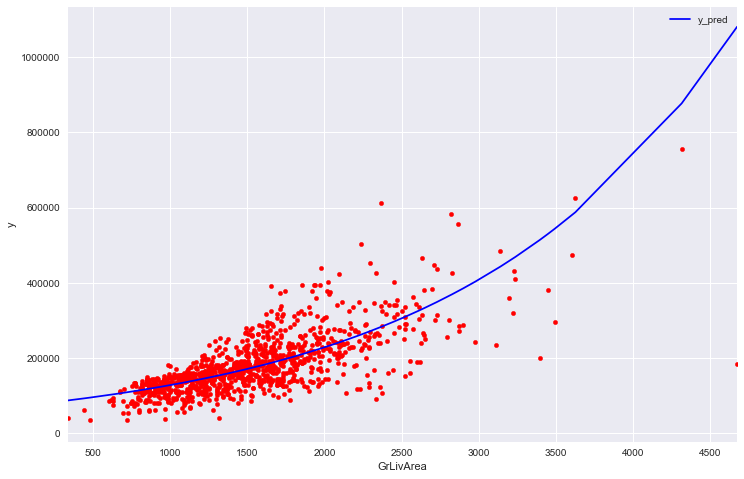

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                 0.0710573459383
Method:                          IRLS   Log-Likelihood:                -13309.
Date:                Thu, 11 Jan 2018   Deviance:                       82.329
Time:                        20:54:16   Pearson chi2:                     77.7
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1756      0.025    445.993      0.000      11.126      11.225
GrLivArea      0.0006   1.56e-05     37.268      0.0

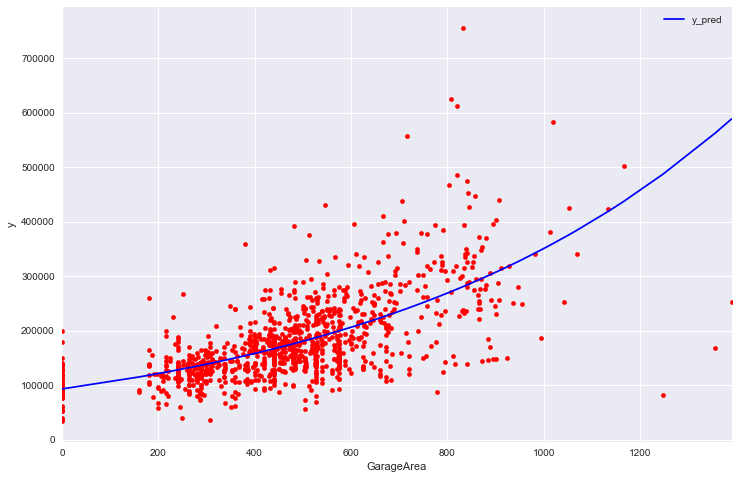

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.087767581638
Method:                          IRLS   Log-Likelihood:                -13390.
Date:                Thu, 11 Jan 2018   Deviance:                       95.459
Time:                        20:54:16   Pearson chi2:                     95.9
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4388      0.022    520.078      0.000      11.396      11.482
GarageArea     0.0013   4.26e-05     31.213      0.0

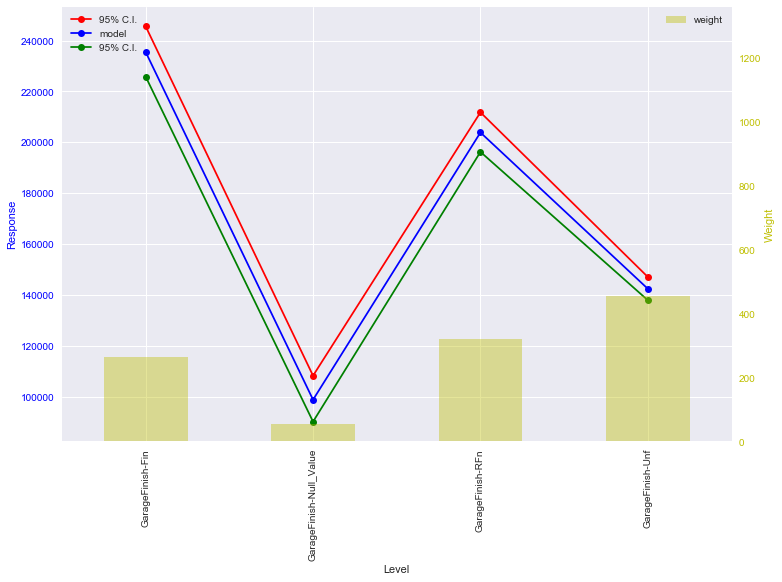

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1091
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                  0.121460078451
Method:                          IRLS   Log-Likelihood:                -13501.
Date:                Thu, 11 Jan 2018   Deviance:                       114.92
Time:                        20:54:16   Pearson chi2:                     133.
No. Iterations:                     4                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
GarageFinish-Fin           12.3695      0.021    577.774      0.000      12.328      12.411
GarageFinish-

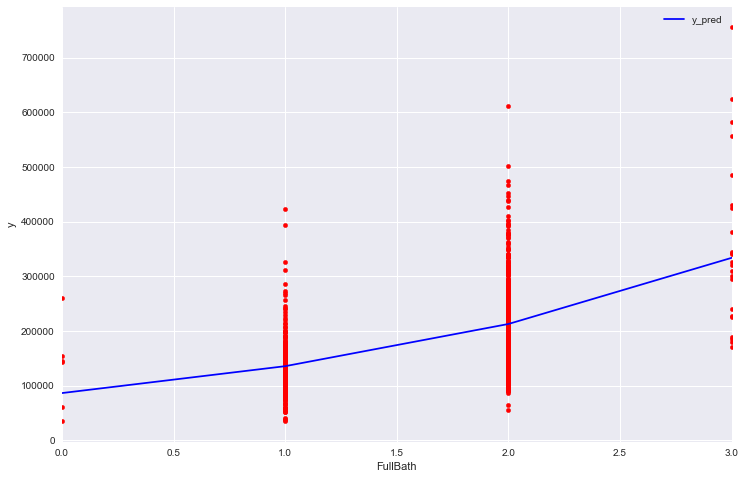

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.112436355781
Method:                          IRLS   Log-Likelihood:                -13487.
Date:                Thu, 11 Jan 2018   Deviance:                       112.97
Time:                        20:54:16   Pearson chi2:                     123.
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3676      0.031    368.762      0.000      11.307      11.428
FullBath       0.4501      0.019     24.259      0.0

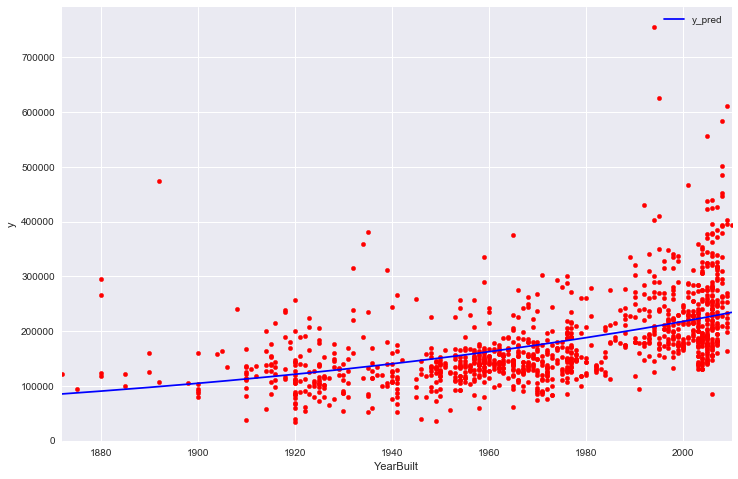

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.141716852484
Method:                          IRLS   Log-Likelihood:                -13550.
Date:                Thu, 11 Jan 2018   Deviance:                       123.70
Time:                        20:54:17   Pearson chi2:                     155.
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3379      0.743     -3.148      0.002      -3.794      -0.882
YearBuilt      0.0073      0.000     19.411      0.0

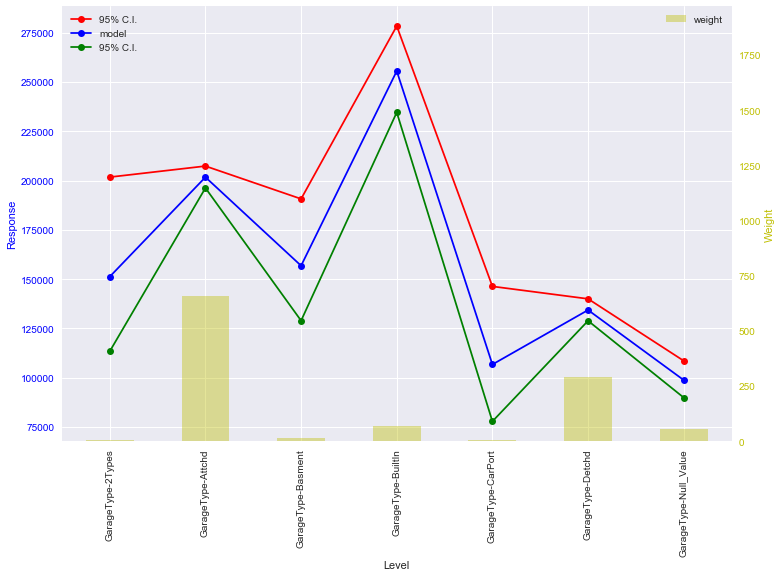

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1088
Model Family:                   Gamma   Df Model:                            6
Link Function:                    log   Scale:                  0.129586952618
Method:                          IRLS   Log-Likelihood:                -13533.
Date:                Thu, 11 Jan 2018   Deviance:                       121.67
Time:                        20:54:17   Pearson chi2:                     141.
No. Iterations:                     4                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
GarageType-2Types        11.9269      0.147     81.156      0.000      11.639      12.215
GarageType-Attchd  

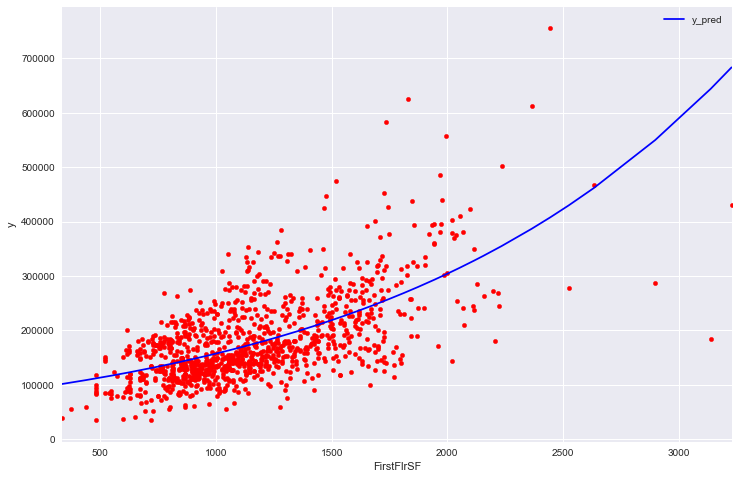

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.102964993189
Method:                          IRLS   Log-Likelihood:                -13474.
Date:                Thu, 11 Jan 2018   Deviance:                       110.84
Time:                        20:54:17   Pearson chi2:                     113.
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3078      0.031    359.246      0.000      11.246      11.370
FirstFlrSF     0.0007   2.58e-05     25.548      0.0

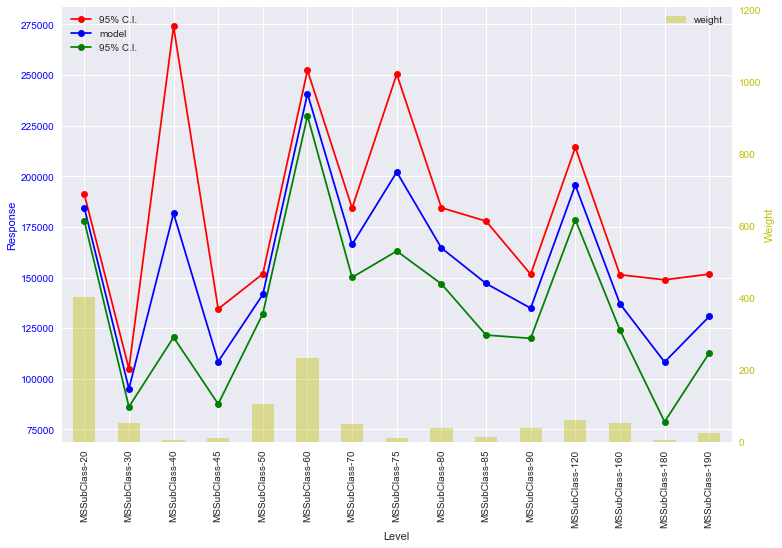

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1080
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                  0.131730113452
Method:                          IRLS   Log-Likelihood:                -13537.
Date:                Thu, 11 Jan 2018   Deviance:                       122.32
Time:                        20:54:18   Pearson chi2:                     142.
No. Iterations:                     4                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
MSSubClass-20     12.1254      0.018    670.664      0.000      12.090      12.161
MSSubClass-30     11.4627      0.050    

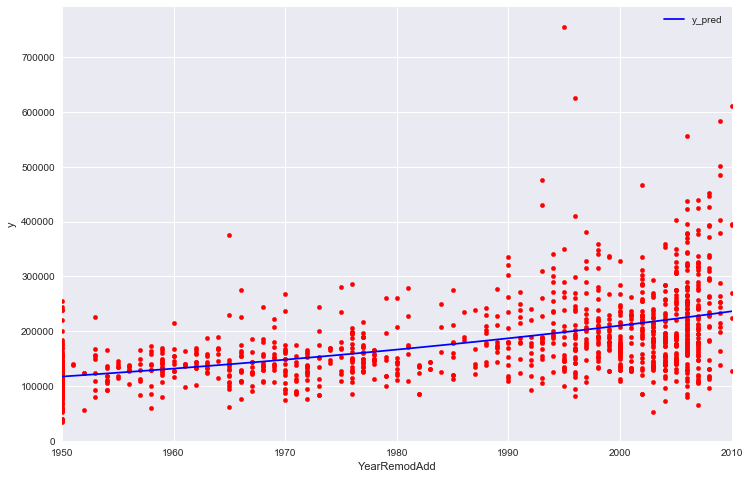

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.120242725288
Method:                          IRLS   Log-Likelihood:                -13521.
Date:                Thu, 11 Jan 2018   Deviance:                       119.92
Time:                        20:54:18   Pearson chi2:                     131.
No. Iterations:                     5                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -11.1065      1.011    -10.983      0.000     -13.089      -9.125
YearRemodAdd     0.0117      0.001     22.927 

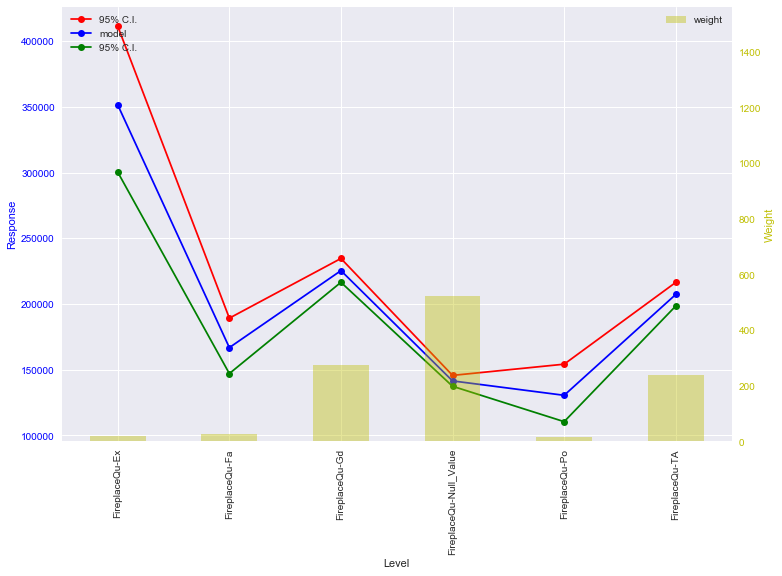

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1089
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                  0.115852278008
Method:                          IRLS   Log-Likelihood:                -13523.
Date:                Thu, 11 Jan 2018   Deviance:                       121.01
Time:                        20:54:18   Pearson chi2:                     126.
No. Iterations:                     4                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
FireplaceQu-Ex            12.7699      0.080    159.174      0.000      12.613      12.927
FireplaceQu-Fa  

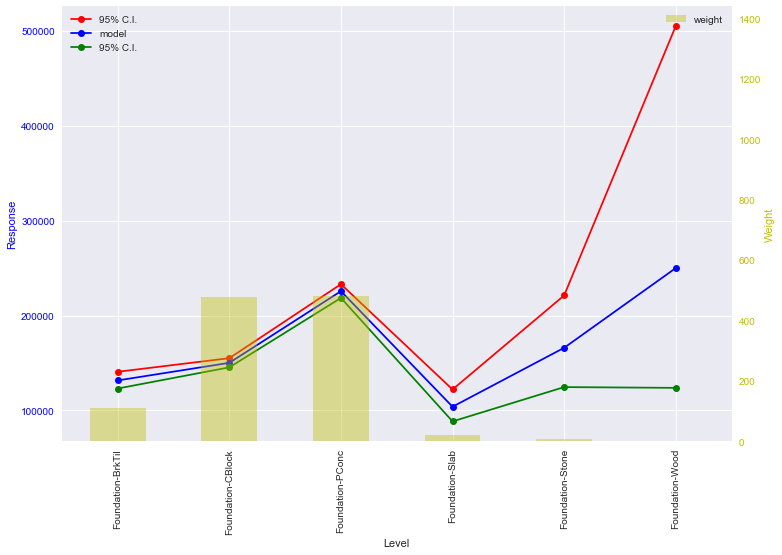

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1089
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                   0.12877357071
Method:                          IRLS   Log-Likelihood:                -13544.
Date:                Thu, 11 Jan 2018   Deviance:                       124.65
Time:                        20:54:19   Pearson chi2:                     140.
No. Iterations:                     4                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Foundation-BrkTil    11.7872      0.034    344.505      0.000      11.720      11.854
Foundation-CBlock    11.9192   

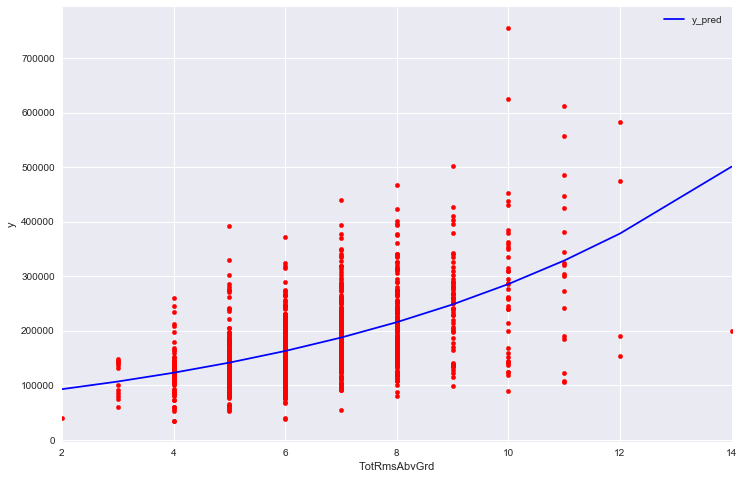

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.113667737607
Method:                          IRLS   Log-Likelihood:                -13528.
Date:                Thu, 11 Jan 2018   Deviance:                       122.17
Time:                        20:54:19   Pearson chi2:                     124.
No. Iterations:                     5                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.1578      0.042    264.133      0.000      11.075      11.241
TotRmsAbvGrd     0.1404      0.006     22.447 

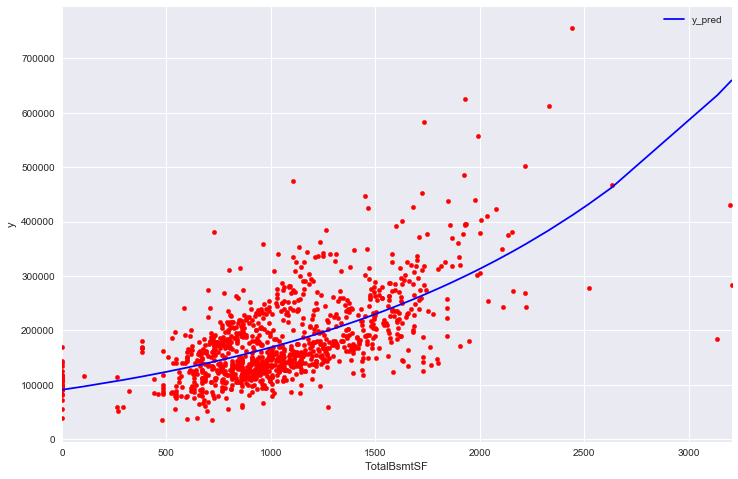

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.100472074222
Method:                          IRLS   Log-Likelihood:                -13451.
Date:                Thu, 11 Jan 2018   Deviance:                       106.43
Time:                        20:54:19   Pearson chi2:                     110.
No. Iterations:                     4                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.4186      0.026    432.324      0.000      11.367      11.470
TotalBsmtSF     0.0006   2.33e-05     26.501     

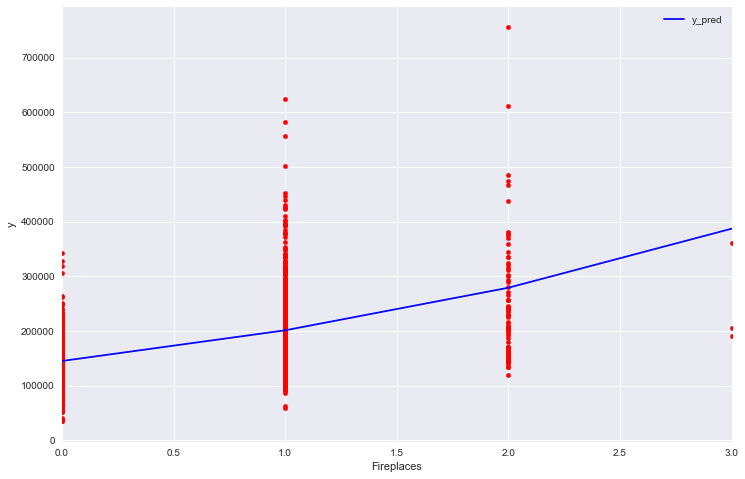

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.131109763061
Method:                          IRLS   Log-Likelihood:                -13583.
Date:                Thu, 11 Jan 2018   Deviance:                       134.34
Time:                        20:54:19   Pearson chi2:                     143.
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8853      0.015    787.985      0.000      11.856      11.915
Fireplaces     0.3269      0.017     19.097      0.0

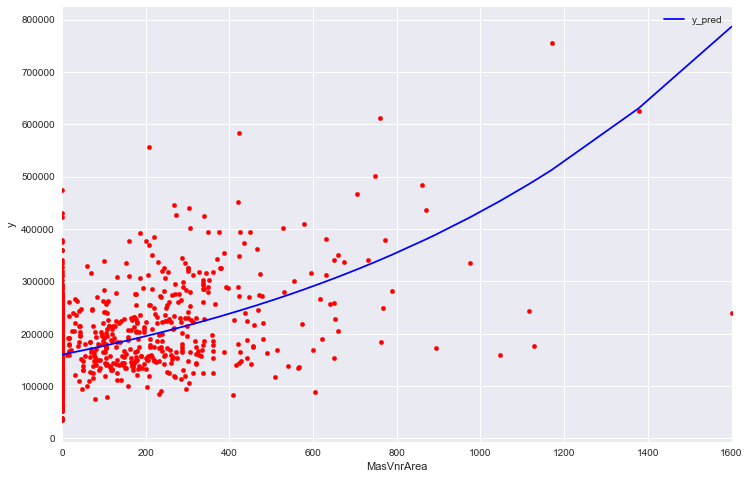

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.133833421225
Method:                          IRLS   Log-Likelihood:                -13611.
Date:                Thu, 11 Jan 2018   Deviance:                       141.68
Time:                        20:54:20   Pearson chi2:                     146.
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9837      0.013    943.700      0.000      11.959      12.009
MasVnrArea     0.0010   6.02e-05     16.523      0.0

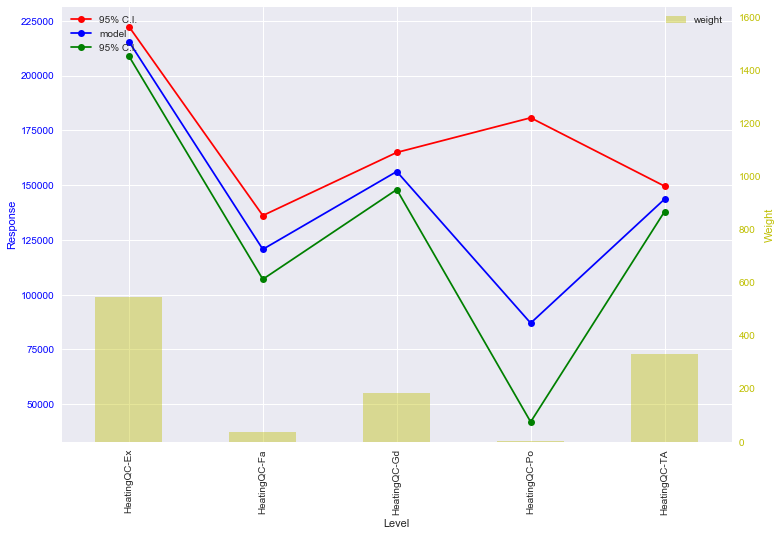

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1090
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                  0.139127725372
Method:                          IRLS   Log-Likelihood:                -13597.
Date:                Thu, 11 Jan 2018   Deviance:                       137.22
Time:                        20:54:20   Pearson chi2:                     152.
No. Iterations:                     4                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
HeatingQC-Ex    12.2808      0.016    769.338      0.000      12.250      12.312
HeatingQC-Fa    11.7009      0.061    190.816 

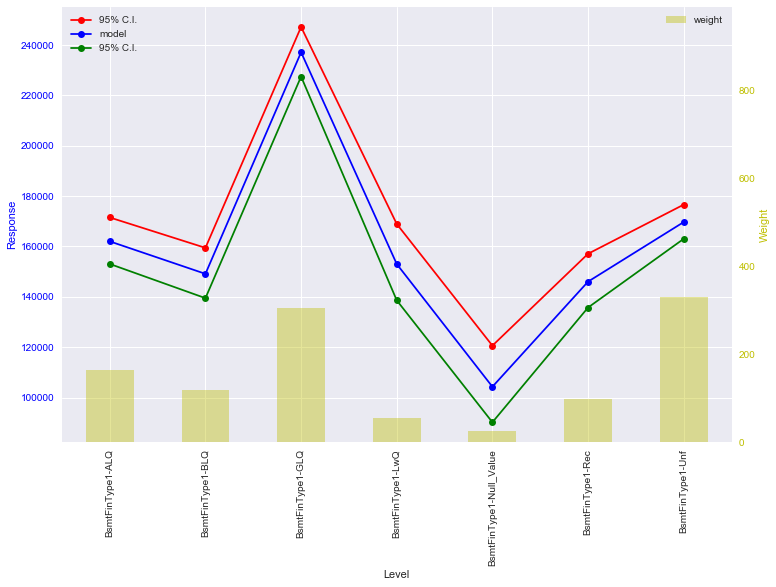

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1088
Model Family:                   Gamma   Df Model:                            6
Link Function:                    log   Scale:                  0.137568272729
Method:                          IRLS   Log-Likelihood:                -13594.
Date:                Thu, 11 Jan 2018   Deviance:                       136.76
Time:                        20:54:21   Pearson chi2:                     150.
No. Iterations:                     4                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
BsmtFinType1-ALQ           11.9956      0.029    412.909      0.000      11.939      12.052
BsmtFinType1-

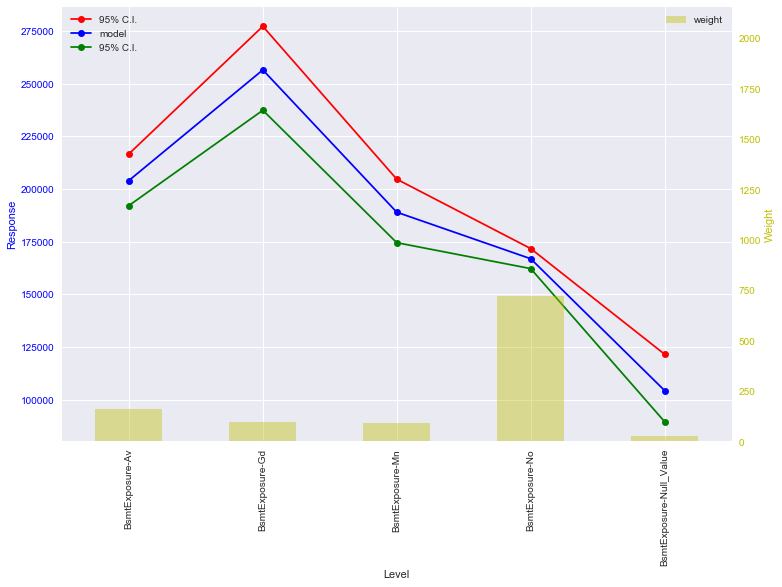

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1090
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                  0.152142740303
Method:                          IRLS   Log-Likelihood:                -13659.
Date:                Thu, 11 Jan 2018   Deviance:                       153.85
Time:                        20:54:21   Pearson chi2:                     166.
No. Iterations:                     4                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
BsmtExposure-Av            12.2259      0.031    398.945      0.000      12.166      12.286
BsmtExposure-

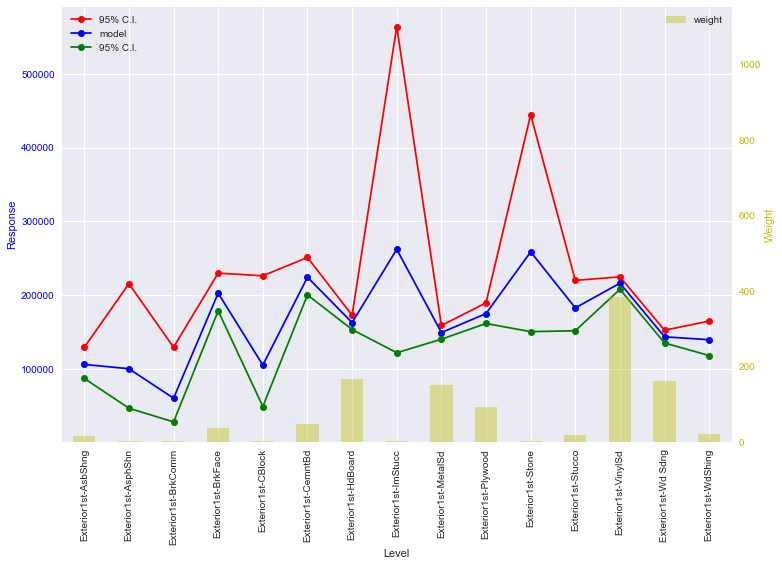

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1080
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                  0.153138705527
Method:                          IRLS   Log-Likelihood:                -13624.
Date:                Thu, 11 Jan 2018   Deviance:                       143.00
Time:                        20:54:22   Pearson chi2:                     165.
No. Iterations:                     5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Exterior1st-AsbShng    11.5694      0.101    114.503      0.000      11.371      11.767
Exterior1st-AsphShn    11

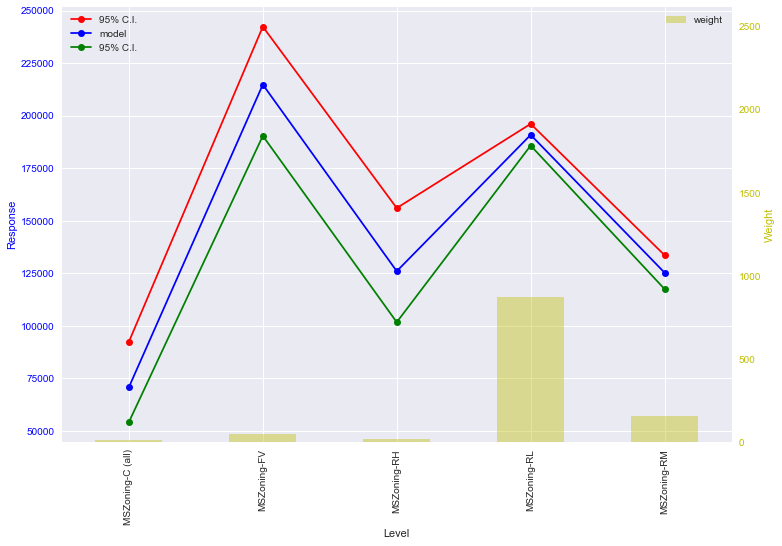

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1090
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                  0.166677610553
Method:                          IRLS   Log-Likelihood:                -13657.
Date:                Thu, 11 Jan 2018   Deviance:                       150.67
Time:                        20:54:22   Pearson chi2:                     182.
No. Iterations:                     4                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
MSZoning-C (all)    11.1677      0.136     82.063      0.000      10.901      11.434
MSZoning-FV         12.2775      0

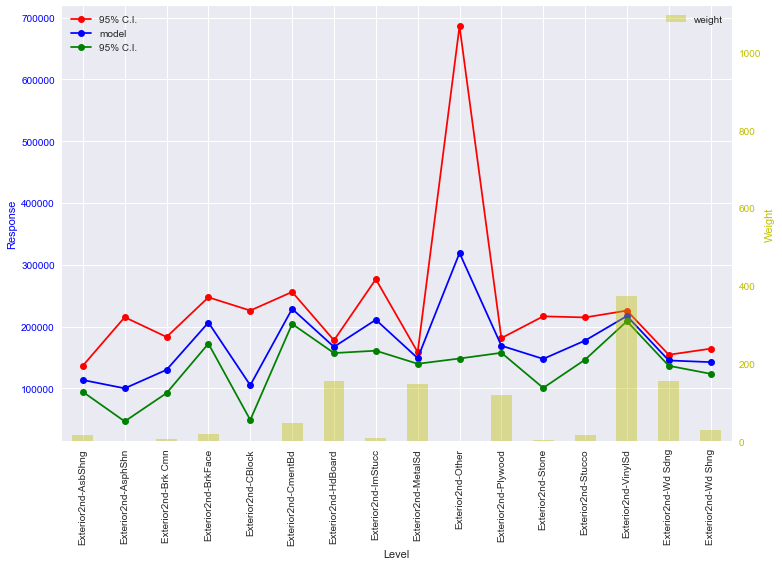

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1079
Model Family:                   Gamma   Df Model:                           15
Link Function:                    log   Scale:                  0.152799496012
Method:                          IRLS   Log-Likelihood:                -13628.
Date:                Thu, 11 Jan 2018   Deviance:                       144.24
Time:                        20:54:23   Pearson chi2:                     165.
No. Iterations:                     5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Exterior2nd-AsbShng    11.6397      0.095    122.773      0.000      11.454      11.825
Exterior2nd-AsphShn    11

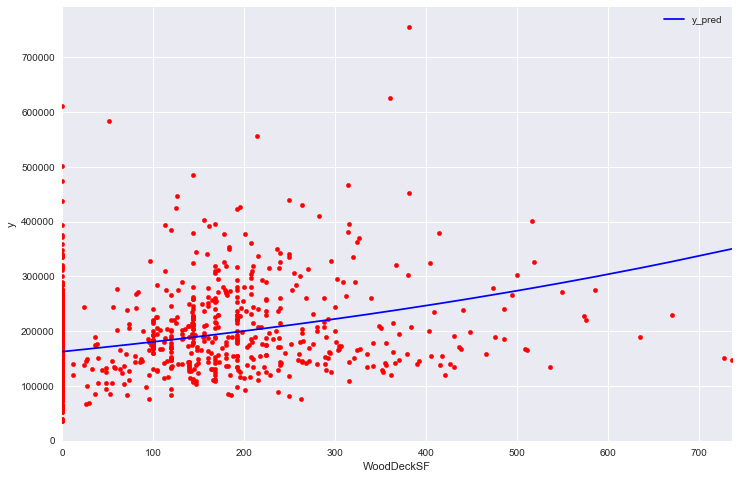

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.167983987865
Method:                          IRLS   Log-Likelihood:                -13691.
Date:                Thu, 11 Jan 2018   Deviance:                       161.94
Time:                        20:54:23   Pearson chi2:                     184.
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9978      0.015    778.187      0.000      11.968      12.028
WoodDeckSF     0.0010   9.74e-05     10.716      0.0

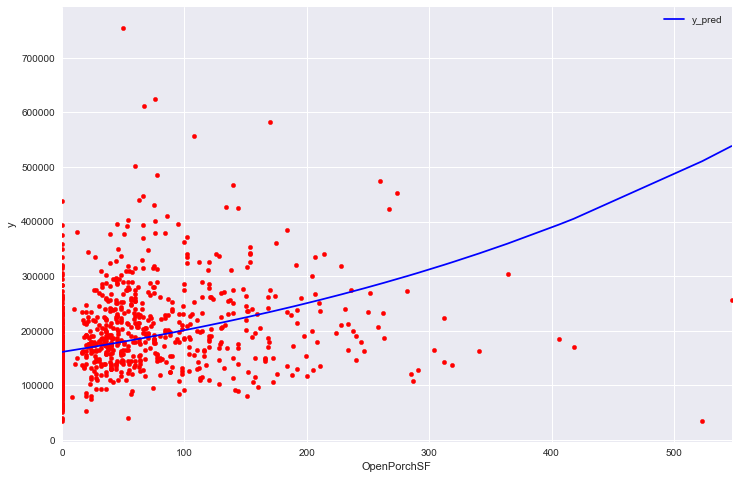

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1093
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.162730872913
Method:                          IRLS   Log-Likelihood:                -13681.
Date:                Thu, 11 Jan 2018   Deviance:                       159.34
Time:                        20:54:23   Pearson chi2:                     178.
No. Iterations:                     8                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.9903      0.015    805.699      0.000      11.961      12.019
OpenPorchSF     0.0022      0.000     12.265     

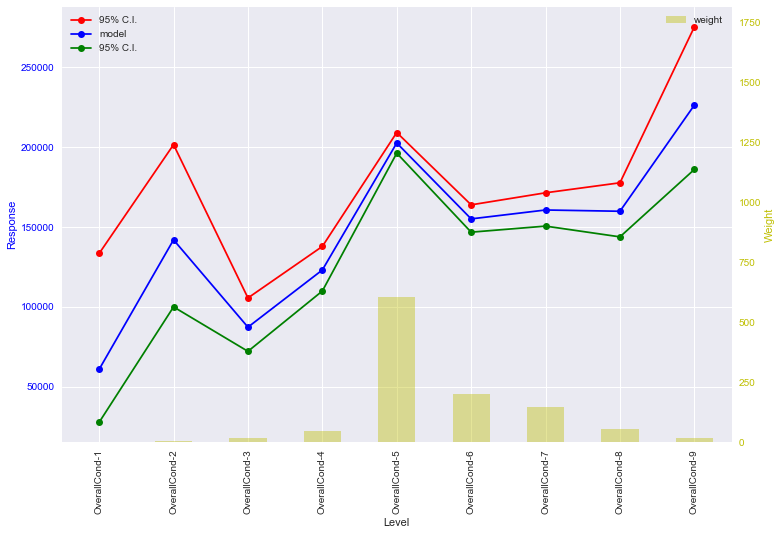

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1095
Model:                            GLM   Df Residuals:                     1086
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                  0.159569509482
Method:                          IRLS   Log-Likelihood:                -13650.
Date:                Thu, 11 Jan 2018   Deviance:                       149.94
Time:                        20:54:24   Pearson chi2:                     173.
No. Iterations:                     5                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
OverallCond-1    11.0186      0.399     27.584      0.000      10.236      11.802
OverallCond-2    11.8635      0.179     66.

In [6]:
warnings.filterwarnings('ignore')

features = ModelTools.FeatureIndexes(dataset, dataset_enc, target_enc)
ModelTools.UnivariateAnalysis(features, X_train, Y_train, X_val, Y_val, p_top_k_features=30, p_model='continuous', p_metric = 'L1 Error', p_n_buckets = 10)

<a name="random-forest-univariate-analysis"></a>
## Random Forest Univariate Analysis

The idea here is to start with all the predictors and iteratively remove one variable at a time, and calculate the loss in overall fit. A larger loss in fit implies a higher marginal importance of the variable. This gives a slightly different perspective than the linear univariate analysis above. Given a group of correlated and highly predictive variables, they will all come through as predictive in the section above since one variable is being fitted at a time, whereas here removing one of these variables should not affect the overall fit too much since the other correlated variables should pick up the lost signal. Here the focus is more on unique contribution of each variable. 
<br>
To avoid over-fitting, p_cross_validations (defaulted to 5) will be used for cross-validation using p_validation_fraction (defaulted to 0.25) for the test set size. In order to reduce run-time, instead of actually removing variables and re-fitting, we will fit the model on the training set and then randomize the variable we would like to remove in order to break any relationship between it and the target variable. This allows us to fit the model once (for each cross-validation set) and infer for each of our predictors instead of re-fitting it for each of our predictors. 

In [7]:
ModelTools.UnivariateRandomForestPermutations(p_features = features,
                                              p_X_train = X_train,
                                              p_Y_train = Y_train,
                                              p_regression = True,
                                              p_metric = 'L1 Error')

*********Features sorted by their L1 error based score:**********
GrLivArea: 0.41510
YearBuilt: 0.13945
GarageCars: 0.12920
TotalBsmtSF: 0.10542
FirstFlrSF: 0.06773
BsmtFinSF1: 0.05084
YearRemodAdd: 0.05081
GarageArea: 0.04463
ExterQual: 0.03958
OverallQual: 0.03673
LotArea: 0.03540
BsmtQual: 0.02911
KitchenQual: 0.01856
MasVnrArea: 0.01487
CentralAir: 0.01279
Neighborhood: 0.00952
WoodDeckSF: 0.00931
BsmtUnfSF: 0.00906
Fireplaces: 0.00898
FireplaceQu: 0.00855
GarageYrBlt: 0.00834
BsmtExposure: 0.00614
SecondFlrSF: 0.00579
OverallCond: 0.00530
MSZoning: 0.00504
OpenPorchSF: 0.00432
GarageType: 0.00416
KitchenAbvGr: 0.00404
TotRmsAbvGrd: 0.00374
BsmtFinType1: 0.00340
BldgType: 0.00282
BedroomAbvGr: 0.00279
HalfBath: 0.00271
FullBath: 0.00254
MoSold: 0.00238
LotShape: 0.00230
BsmtFullBath: 0.00216
HeatingQC: 0.00201
SaleType: 0.00194
LandSlope: 0.00189
Exterior1st: 0.00180
MSSubClass: 0.00165
SaleCondition: 0.00162
GarageQual: 0.00154
RoofMatl: 0.00148
BsmtCond: 0.00144
LotConfig: 0.0013

<a name="gradient-boosting-univariate-analysis"></a>
## Gradient Boosting Univariate Analysis

This section is analagous to the Random Forest Univariate Analysis section above, except using Gradient Boosting models instead of Random Forest models. 

In [8]:
ModelTools.UnivariateGradientBoostingPermutations(p_features = features,
                                                  p_X_train = X_train,
                                                  p_Y_train = Y_train,
                                                  p_regression = True,
                                                  p_metric = 'L1 Error')

*********Features sorted by their L1 error based score:**********
GrLivArea: 0.22440
TotalBsmtSF: 0.07276
KitchenQual: 0.04017
FirstFlrSF: 0.03700
YearRemodAdd: 0.02914
GarageYrBlt: 0.02442
OverallQual: 0.02232
YearBuilt: 0.02052
BsmtFinSF1: 0.01896
LotArea: 0.01855
GarageCars: 0.01352
BsmtFinType1: 0.01313
Fireplaces: 0.01219
GarageArea: 0.01183
WoodDeckSF: 0.01095
FireplaceQu: 0.00978
GarageType: 0.00910
HalfBath: 0.00787
ExterQual: 0.00648
BsmtExposure: 0.00563
MasVnrArea: 0.00521
OpenPorchSF: 0.00509
Neighborhood: 0.00503
CentralAir: 0.00397
RoofStyle: 0.00372
BsmtQual: 0.00351
SecondFlrSF: 0.00282
HeatingQC: 0.00275
BedroomAbvGr: 0.00266
MSZoning: 0.00219
Exterior1st: 0.00213
MSSubClass: 0.00133
MasVnrType: 0.00105
FullBath: 0.00093
TotRmsAbvGrd: 0.00091
LandContour: 0.00088
MoSold: 0.00040
LandSlope: 0.00038
KitchenAbvGr: 0.00034
ExterCond: 0.00017
Exterior2nd: 0.00012
GarageCond: 0.00010
Functional: 0.00010
ScreenPorch: 0.00010
RoofMatl: 0.00009
Electrical: 0.00008
LotConfig: 0.

<a name="part-two---model-comparison"></a>
# Part Two - Model Comparison

Early in the modeling process a decision needs to made about which type of model to use. This choice should be driven by the nature of the modeling problem, the nature of the data, and the relationship between the predictors and the target variable. Even after these considerations have been made there are often multiple viable options. This section compares the fit of different models using all of the predictor variables (this can be changed the p_predictors argument). Within the code you can choose the set of hyperparameters you want to test for each model. Soon there will be an additional section here to do a hyperparameter search using some combination of Bayesian Optimization, grid search, and random search.

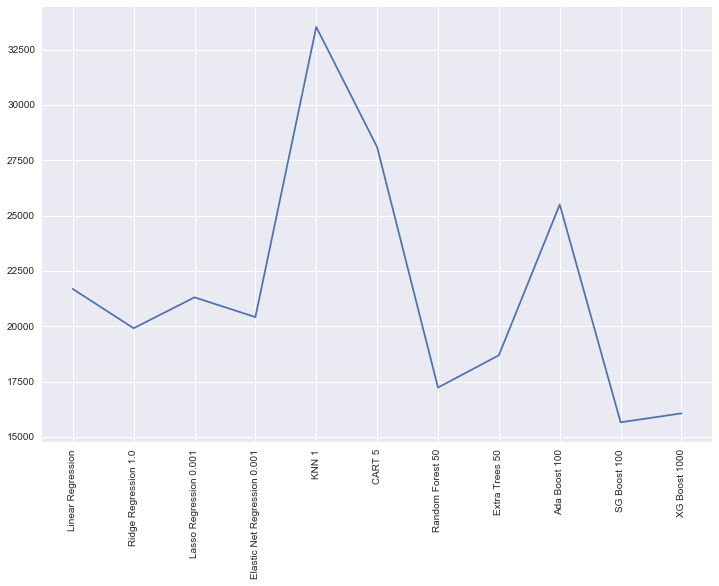

                           Model  Validation Error
9                   SG Boost 100      15661.506292
10                 XG Boost 1000      16064.065679
6               Random Forest 50      17229.292658
7                 Extra Trees 50      18689.356384
1           Ridge Regression 1.0      19909.770704
3   Elastic Net Regression 0.001      20414.244964
2         Lasso Regression 0.001      21305.917454
0              Linear Regression      21684.667052
8                  Ada Boost 100      25497.799053
5                         CART 5      28093.146683
4                          KNN 1      33520.632877


In [9]:
#warnings.filterwarnings('ignore')

ModelTools.ModelComparisonRegression(p_X_train = X_train,
                                     p_X_val = X_val,
                                     p_Y_train = Y_train,
                                     p_Y_val = Y_val,
                                     p_predictors = predictors_enc,
                                     p_metric = 'L1')   

<a name="part-three---variable-selection"></a>
# Part Three - Variable Selection

Once a model has been chosen, we need to decide which predictor variables to include. Variable selection will be done using backward and forward stepwise selection. The backward part of this algorithm begins by starting with all, say $n$, predictor variables and iteratively removing one variable at a time and measuring the change in performance. The worst performing variable is then removed from the model. We repeat the process with the $n-1$ remaining variables, again removing the worst performing variable. This continues until all of the remaining variables make a "significant" contribution to the model fit. The specific stopping criteria will depend on the problem and metric that is chosen. The forward stepwise selection will then be run (if p_forward = True), by iteratively adding each of the variables that were removed in the backward selection. The most significant, if there any, will be added back to the model. This process continues until none of the remaining variables significantly improve the model.
<br>
It may not be immediately clear why the forward iteration is useful. The backward (and forward) stepwise selection is a greedy algorithm and may find a local optimum in the feature space. Running the forward iteration will increase the chance of finding the global optimum, however does not guarantee it. Ideally we would compare the model fit on every subset of our preditor variables, however this is computationally expensive with $O(2^n)$ run-time, compared to $O(n^2)$ run-time with the backward/forward selection.

<a name="random-forest"></a>
## Random Forest

Here we run backward and forward stepwise selection with Random Forest models. Similar to the univariate random forest section we will cross-validate using p_cross_validations splits and p_validation_fraction portion of the data in each test set. And again to reduce run-time, instead of removing variables and re-fitting, we will randomize the variable we would like to remove which should have the same effect. 

In [10]:
ModelTools.ForBackRandomForestPremutations(p_features = features,
                                           p_predictors = predictors_enc,
                                           p_X_train = X_train,
                                           p_Y_train = Y_train,
                                           p_X_val = X_val,
                                           p_Y_val = Y_val,
                                           p_regression = True,
                                           p_metric = 'L1 Error')

*******Variable Performance From Final Backward Iteration:*******
GrLivArea: 0.42036
YearBuilt: 0.13931
GarageCars: 0.13319
TotalBsmtSF: 0.10994
FirstFlrSF: 0.07010
BsmtFinSF1: 0.05533
YearRemodAdd: 0.05353
GarageArea: 0.04347
OverallQual: 0.04003
LotArea: 0.03921
ExterQual: 0.03920
BsmtQual: 0.03149
KitchenQual: 0.01954
MasVnrArea: 0.01759
CentralAir: 0.01255
Neighborhood: 0.01104
FireplaceQu: 0.01062
BsmtUnfSF: 0.01056
WoodDeckSF: 0.01051
GarageYrBlt: 0.00900
Fireplaces: 0.00789
BsmtExposure: 0.00779
MSZoning: 0.00597
GarageType: 0.00588
OverallCond: 0.00587
SecondFlrSF: 0.00525
TotRmsAbvGrd: 0.00422
KitchenAbvGr: 0.00420
OpenPorchSF: 0.00409
BldgType: 0.00348
BsmtFinType1: 0.00344
BedroomAbvGr: 0.00299
MoSold: 0.00281
BsmtFullBath: 0.00276
HalfBath: 0.00250
LotShape: 0.00228
LandSlope: 0.00209
HeatingQC: 0.00208
RoofMatl: 0.00208
LandContour: 0.00194
FullBath: 0.00190
SaleCondition: 0.00189
Exterior1st: 0.00188
ExterCond: 0.00181
BsmtCond: 0.00158
SaleType: 0.00156
GarageQual: 0.001

<a name="gradient-boosting"></a>
## Gradient Boosting

This section is analagous to the one above, except using gradient boosting.

In [11]:
ModelTools.ForBackGradientBoostingPremutations(p_features = features,
                                               p_predictors = predictors_enc,
                                               p_X_train = X_train,
                                               p_Y_train = Y_train,
                                               p_X_val = X_val,
                                               p_Y_val = Y_val,
                                               p_regression = True,
                                               p_metric = 'L1 Error')

*******Variable Performance From Final Backward Iteration:*******
GrLivArea: 0.25223
TotalBsmtSF: 0.07277
KitchenQual: 0.05296
YearBuilt: 0.04650
FirstFlrSF: 0.03637
YearRemodAdd: 0.03371
GarageYrBlt: 0.02780
GarageCars: 0.02523
BsmtFinSF1: 0.02381
OverallQual: 0.02205
LotArea: 0.01762
WoodDeckSF: 0.01406
FireplaceQu: 0.01303
BsmtFinType1: 0.01294
GarageType: 0.01238
GarageArea: 0.01227
ExterQual: 0.00787
BsmtExposure: 0.00779
Fireplaces: 0.00777
OpenPorchSF: 0.00752
BsmtQual: 0.00740
RoofStyle: 0.00677
HalfBath: 0.00645
Neighborhood: 0.00495
Exterior1st: 0.00412
HeatingQC: 0.00342
SecondFlrSF: 0.00317
CentralAir: 0.00311
MasVnrArea: 0.00282
BedroomAbvGr: 0.00202
MSZoning: 0.00170
MoSold: 0.00069
Functional: 0.00038
ScreenPorch: 0.00030
Electrical: 0.00027
KitchenAbvGr: 0.00024
Condition2: 0.00017
BsmtHalfBath: 0.00001
Street: 0.00000
ThreeSsnPorch: 0.00000
GarageYrBlt_ISNULL: 0.00000
Utilities: 0.00000
Alley: 0.00000
PoolArea: 0.00000
PoolQC: 0.00000
Heating: 0.00000
MiscVal: 0.00000
